<a href="https://colab.research.google.com/github/kasparmartens/NeuralDecomposition/blob/master/toy_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade git+https://github.com/kasparmartens/NeuralDecomposition.git

Necessary imports

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from ND.encoder import cEncoder
from ND.decoder import Decoder
from ND.CVAE import CVAE
from ND.helpers import expand_grid

from torch.utils.data import TensorDataset, DataLoader

from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal

Choose device (i.e. CPU or GPU)

In [3]:
device = "cuda"

Generate a synthetic data set (700 data points, 5 features)

In [5]:
N = 700

# generate ground truth latent variable z and covariate c
z = Uniform(-2.0, 2.0).sample((N, 1))
c = Uniform(-2.0, 2.0).sample((N, 1))
noise_sd = 0.05

# generate five features
y1 = torch.exp(-z**2) - 0.2*c
y2 = torch.sin(z) + 0.2*c + 0.7*torch.sin(z)*(z > 0).float()*c
y3 = torch.tanh(z) + 0.2*c
y4 = 0.2*z + torch.tanh(c)
y5 = 0.1*z

Y = torch.cat([y1, y2, y3, y4, y5], dim=1)
Y += noise_sd * torch.randn_like(Y)

Y = (Y - Y.mean(axis=0, keepdim=True)) / Y.std(axis=0, keepdim=True)

data_dim = Y.shape[1]
n_covariates = 1
hidden_dim = 32

For model fitting, we will need a `DataLoader` object

In [6]:
dataset = TensorDataset(Y.to(device), c.to(device))
data_loader = DataLoader(dataset, shuffle=True, batch_size=64)

Setting up the CVAE encoder + decoder

In [7]:
### ENCODER

# define encoder which maps (data, covariate) -> (z_mu, z_sigma)
encoder_mapping = nn.Sequential(
    nn.Linear(data_dim + n_covariates, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, 2)
)

encoder = cEncoder(z_dim=1, mapping=encoder_mapping)

In [8]:
### DECOMPOSABLE DECODER

# grid needed for quadrature
grid_z = torch.linspace(-2.0, 2.0, steps=15).reshape(-1, 1).to(device)
grid_c = torch.linspace(-2.0, 2.0, steps=15).reshape(-1, 1).to(device)
grid_cz = torch.cat(expand_grid(grid_z, grid_c), dim=1).to(device)

decoder_z = nn.Sequential(
    nn.Linear(1, hidden_dim),
    nn.Tanh(),
    nn.Linear(hidden_dim, data_dim)
)

decoder_c = nn.Sequential(
    nn.Linear(1, hidden_dim),
    nn.Tanh(),
    nn.Linear(hidden_dim, data_dim)
)

decoder_cz = nn.Sequential(
    nn.Linear(2, hidden_dim),
    nn.Tanh(),
    nn.Linear(hidden_dim, data_dim)
)

decoder = Decoder(data_dim, 
                  grid_z, grid_c, grid_cz, 
                  decoder_z, decoder_c, decoder_cz,
                  has_feature_level_sparsity=True, p1=0.1, p2=0.1, p3=0.1, 
                  lambda0=1e2, penalty_type="MDMM",
                  device=device)

Combine the encoder + decoder and fit the decomposable CVAE

In [10]:
model = CVAE(encoder, decoder, lr=5e-3, device=device)

loss, integrals = model.optimize(data_loader,
                                 n_iter=25000, 
                                 augmented_lagrangian_lr=0.1)


Fitting Neural Decomposition.
	Data set size 700. # iterations = 25000 (i.e. # epochs <= 2273)

	Iter     0.	Total loss 2450.817
	Iter   500.	Total loss 180.176
	Iter  1000.	Total loss 227.483
	Iter  1500.	Total loss 74.663
	Iter  2000.	Total loss 97.057
	Iter  2500.	Total loss 38.784
	Iter  3000.	Total loss 88.503
	Iter  3500.	Total loss 40.051
	Iter  4000.	Total loss 5.188
	Iter  4500.	Total loss 49.019
	Iter  5000.	Total loss 14.347
	Iter  5500.	Total loss 4.594
	Iter  6000.	Total loss -15.171
	Iter  6500.	Total loss -37.147
	Iter  7000.	Total loss -22.785
	Iter  7500.	Total loss -31.854
	Iter  8000.	Total loss 22.298
	Iter  8500.	Total loss -16.891
	Iter  9000.	Total loss 10.996
	Iter  9500.	Total loss -23.683
	Iter 10000.	Total loss -27.154
	Iter 10500.	Total loss -69.599
	Iter 11000.	Total loss -47.005
	Iter 11500.	Total loss -37.925
	Iter 12000.	Total loss -36.546
	Iter 12500.	Total loss -50.022
	Iter 13000.	Total loss -53.571
	Iter 13500.	Total loss -54.689
	Iter 14000.	Total l

### Diagnostics and interpretation of the model fit

First let's see if the integrals have converged sufficiently close to zero

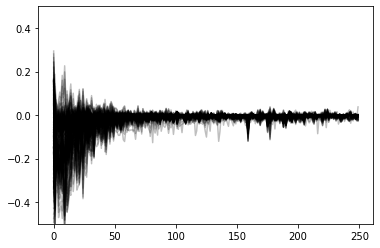

In [12]:
def plot_integrals(integrals):
    n_rep = integrals.shape[0]
    n_iter = integrals.shape[1]
    time = np.arange(n_iter).reshape(-1, 1)
    time_mat = np.tile(time, [1, n_rep])

    plt.plot(time_mat, integrals.T, c="black", alpha=0.25)
    plt.ylim(-0.5, 0.5)

plot_integrals(integrals)

Now let's look at the inferred $z$ values, together with the mappings $z \mapsto \text{features}$

In [13]:
with torch.no_grad():
    # encoding of the entire observed data set
    mu_z, sigma_z = encoder(Y.to(device), c.to(device))
    # predictions from the decoder
    Y_pred = decoder(mu_z, c.to(device))

    # output to CPU
    mu_z, sigma_z = mu_z.cpu(), sigma_z.cpu()
    Y_pred = Y_pred.cpu()

### Correlation between the ground truth $z$ and the inferred $z$ values

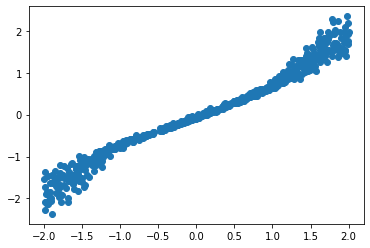

In [14]:
plt.scatter(z, mu_z)

### Visualising mappings from z to feature space

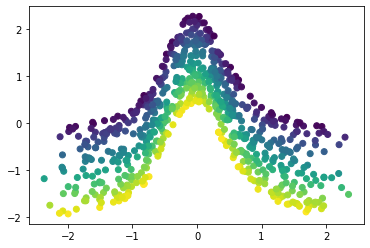

In [15]:
plt.scatter(mu_z, Y_pred[:, 0], c=c.reshape(-1))

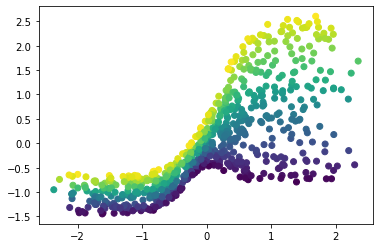

In [16]:
plt.scatter(mu_z, Y_pred[:, 1], c=c.reshape(-1))

### Inferred sparsity masks

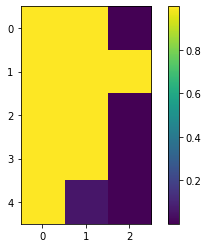

In [17]:
with torch.no_grad():
    sparsity = decoder.get_feature_level_sparsity_probs().cpu()
    
plt.imshow(sparsity)
plt.colorbar()